In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph


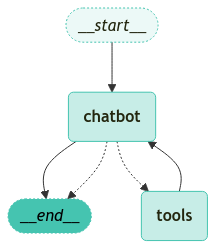

In [37]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]
    dummy_data: Annotated[str, "dummy"]

########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
news_tool = GoogleNews()


@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)

tools = [search_keyword]

# LLM 초기화
llm = ChatOllama(model="llama3.1:8b")
# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
        "dummy_data": "[chatbot] 호출, dummy data",  # 테스트를 위하여 더미 데이터를 추가합니다.
    }

# 상태 그래프 생성
graph_builder = StateGraph(State)
# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)
# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)
# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########
# tools > chatbot
graph_builder.add_edge("tools", "chatbot")
# START > chatbot
graph_builder.add_edge(START, "chatbot")
# chatbot > END
graph_builder.add_edge("chatbot", END)
########## 5. 그래프 컴파일 ##########
# 그래프 빌더 컴파일
graph = graph_builder.compile()

########## 6. 그래프 시각화 ##########
# 그래프 시각화
visualize_graph(graph)


In [23]:
from langchain_core.runnables import RunnableConfig

# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 상태를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-tag"],  # Tag
)


### input이랑 config만 가지고 stream 할 때

In [24]:
for event in graph.stream(input=input, config=config):
    for key, value in event.items():
        print(f"\n[ {key} ]\n")
        # value 에 messages 가 존재하는 경우
        if "messages" in value:
            messages = value["messages"]
            # 가장 최근 메시지 1개만 출력합니다.
            value["messages"][-1].pretty_print()


[ chatbot ]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (eca1977d-d6a2-468b-92aa-5998a0938a22)
 Call ID: eca1977d-d6a2-468b-92aa-5998a0938a22
  Args:
    query: 2024년 노벨 문학상

[ tools ]

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiUEFVX3lxTFBUN1pNdlpOdWNIZjcyUnhmYjZnQjBQSjA0ZFVuNW5MUWM5X1NzRWRYVk5WUjh3dTJKUGJsR2ZWWURua0d4d0k4VWNWbktIQmN50gFTQVVfeXFMTk8wY193bXgxdXlhZzNObldsSnA2WU9pelRlTkdTN0lUYWVZdVhBaTAydDBtZjVnbnFOVDRpLS1Sck5ncDh0TVVtMWJPRGRodVNacjA?oc=5", "content": "한강, 한국인 최초 노벨문학상 수상…“역사적 트라우마에 맞선 강렬한 시적 산문” - VOA Korea"}, {"url": "https://news.google.com/rss/articles/CBMiaEFVX3lxTE4xVV96b1c5cjZNWHl5VFd3aGZkcDNoSDN0Vmp6a3RNVVl2VG1FOW96RTFOUnpBYkR2OEx3VGRsS3RaQTdvQ3FkcmFRQmd5UmtMd1labGFQS2J6YmpKZ1p4S2xXTUVXQjVS0gFsQVVfeXFMTlctOUd6VTVQRXF6dWpTNnJ2S1d1dndJdGFGN2I1Yjl1bEhVNU03UmpSNUtONFZZZ045bmNZMGgxX3NlQjJydGw

### output_keys 옵션 추가했을 때

In [16]:
# channels 에 정의된 키 목록을 출력합니다.
print(list(graph.channels.keys()))

['messages', 'dummy_data', '__start__', 'chatbot', 'tools', 'branch:__start__:__self__:chatbot', 'branch:__start__:__self__:tools', 'branch:chatbot:__self__:chatbot', 'branch:chatbot:__self__:tools', 'branch:tools:__self__:chatbot', 'branch:tools:__self__:tools', 'start:chatbot', 'branch:chatbot:tools_condition:tools']


In [17]:
for event in graph.stream(
    input=input,
    config=config,
    output_keys=["dummy_data"],  # messages 를 추가해 보세요!
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[ {key} ]\n")

        # dummy_data 가 존재하는 경우
        if value:
            # value 는 노드의 출력값
            print(value.keys())
            # dummy_data key 가 존재하는 경우
            if "dummy_data" in value:
                print(value["dummy_data"])


[ chatbot ]

dict_keys(['dummy_data'])
[chatbot] 호출, dummy data
해당 키워드의 뉴스가 없습니다.

[ tools ]


[ chatbot ]

dict_keys(['dummy_data'])
[chatbot] 호출, dummy data

[ tools ]


[ chatbot ]

dict_keys(['dummy_data'])
[chatbot] 호출, dummy data


In [18]:
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    output_keys=["messages"],  # messages 만 출력
):
    for key, value in event.items():
        # messages 가 존재하는 경우
        if value and "messages" in value:
            # key 는 노드 이름
            print(f"\n[ {key} ]\n")
            # messages 의 마지막 요소의 content 를 출력합니다.
            print(value["messages"][-1].content)


[ chatbot ]



[ tools ]

[{"url": "https://news.google.com/rss/articles/CBMiUEFVX3lxTFBUN1pNdlpOdWNIZjcyUnhmYjZnQjBQSjA0ZFVuNW5MUWM5X1NzRWRYVk5WUjh3dTJKUGJsR2ZWWURua0d4d0k4VWNWbktIQmN50gFTQVVfeXFMTk8wY193bXgxdXlhZzNObldsSnA2WU9pelRlTkdTN0lUYWVZdVhBaTAydDBtZjVnbnFOVDRpLS1Sck5ncDh0TVVtMWJPRGRodVNacjA?oc=5", "content": "한강, 한국인 최초 노벨문학상 수상…“역사적 트라우마에 맞선 강렬한 시적 산문” - VOA Korea"}, {"url": "https://news.google.com/rss/articles/CBMiaEFVX3lxTE4xVV96b1c5cjZNWHl5VFd3aGZkcDNoSDN0Vmp6a3RNVVl2VG1FOW96RTFOUnpBYkR2OEx3VGRsS3RaQTdvQ3FkcmFRQmd5UmtMd1labGFQS2J6YmpKZ1p4S2xXTUVXQjVS0gFsQVVfeXFMTlctOUd6VTVQRXF6dWpTNnJ2S1d1dndJdGFGN2I1Yjl1bEhVNU03UmpSNUtONFZZZ045bmNZMGgxX3NlQjJydGwzUnpwamR6V0hSTWVFbEVKWVA5b3JxQ1NQWmNfVXRhR1AyZ2lG?oc=5", "content": "2024 노벨문학상의 주인공, ‘한강’의 대표 문장 6 - Den"}, {"url": "https://news.google.com/rss/articles/CBMiU0FVX3lxTE9UNHJNX1kwMW00MDJoRngzbW83VGh0VmhkZjYzRGlwNDR1VEpudEM4S2dFajdTa3VCUUdITEl2TEFndFE1NENGZWFCZE4tWnhhbWVn?oc=5", "content": "한강 \"현대사의 비극, 역사의 한 장으로 바꾸는 건 내 의도 아냐\"

### Stream_mode 사용하기

In [19]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

# values 모드로 스트리밍 출력
for event in graph.stream(
    input=input,
    stream_mode="values",  # 기본값
):
    for key, value in event.items():
        # key 는 state 의 key 값
        print(f"\n[ {key} ]\n")
        if key == "messages":
            print(f"메시지 개수: {len(value)}")
            # print(value)
    print("===" * 10, " 단계 ", "===" * 10)



[ messages ]

메시지 개수: 1

[ dummy_data ]

==============================  단계  ==============================

[ messages ]

메시지 개수: 2

[ dummy_data ]

==============================  단계  ==============================
해당 키워드의 뉴스가 없습니다.

[ messages ]

메시지 개수: 3

[ dummy_data ]

==============================  단계  ==============================

[ messages ]

메시지 개수: 4

[ dummy_data ]

==============================  단계  ==============================


In [28]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

# updates 모드로 스트리밍 출력
for event in graph.stream(
    input=input,
    stream_mode="updates",  # 기본값
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[ {key} ]\n")

        # value 는 노드의 출력값
        print(value.keys())

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
            # print(value["messages"])
    print("===" * 10, " 단계 ", "===" * 10)



[ chatbot ]

dict_keys(['messages', 'dummy_data'])
메시지 개수: 1
==============================  단계  ==============================
해당 키워드의 뉴스가 없습니다.

[ tools ]

dict_keys(['messages'])
메시지 개수: 1
==============================  단계  ==============================

[ chatbot ]

dict_keys(['messages', 'dummy_data'])
메시지 개수: 1
==============================  단계  ==============================


### interrupt_before, interrupt_after 옵션

In [32]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",  # 기본값
    interrupt_before=["tools"],  # tools 노드 이전에 스트리밍 중단
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        if isinstance(value, dict):
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
    print("===" * 10, " 단계 ", "===" * 10)



[chatbot]

dict_keys(['messages', 'dummy_data'])
[AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1:8b', 'created_at': '2025-01-24T06:44:42.683615Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2606556625, 'load_duration': 32413041, 'prompt_eval_count': 168, 'prompt_eval_duration': 557000000, 'eval_count': 24, 'eval_duration': 2016000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-71ebb7c9-a39b-46e3-8758-80c8fdae038e-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024년 노벨 문학상'}, 'id': '59eea194-ccbc-4ae6-95d6-3f8dbb29b31f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 24, 'total_tokens': 192})]
메시지 개수: 1
==============================  단계  ==============================

[__interrupt__]

==============================  단계  ==============================


In [39]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스"

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",
    interrupt_after=["tools"],  # tools 실행 후 interrupt
):
    for value in event.values():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        if isinstance(value, dict):
            # value 는 노드의 출력값
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")


[__interrupt__]

dict_keys(['messages', 'dummy_data'])
[AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1:8b', 'created_at': '2025-01-24T06:47:47.843856Z', 'done': True, 'done_reason': 'stop', 'total_duration': 18344854167, 'load_duration': 12241540167, 'prompt_eval_count': 165, 'prompt_eval_duration': 4074000000, 'eval_count': 24, 'eval_duration': 2025000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-52305424-fb61-410c-999e-59c8185d779f-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024년 노벨 문학상'}, 'id': 'c7024d8c-f222-44ed-957a-41014aa28ae0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 165, 'output_tokens': 24, 'total_tokens': 189})]
메시지 개수: 1

[__interrupt__]

dict_keys(['messages'])
[ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMiU0FVX3lxTE9UNHJNX1kwMW00MDJoRngzbW83VGh0VmhkZjYzRGlwNDR1VEpudEM4S2dFajdTa3VCUUdITEl2TEFndFE1NENGZWFCZE4tWnhhbWVn?oc=5", "cont